In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables
Station = Base.classes.station
Measurement = Base.classes.measurement

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print(f"The most recent date in the dataset is: {most_recent_date}")

The most recent date in the dataset is: 2017-08-23


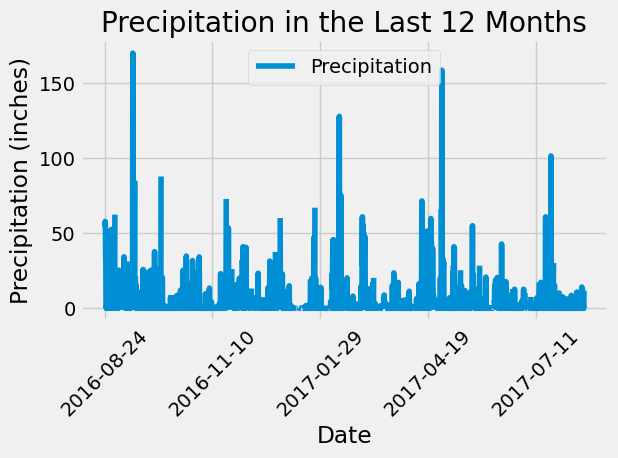

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = session.query(func.max(Measurement.date)).scalar()
one_year_ago = dt.datetime.strptime(last_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', title='Precipitation in the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df['Precipitation'].describe()

print(summary_stats)

count    2015.000000
mean        4.485112
std        11.690532
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print(f"The total number of stations in the dataset is: {total_stations}")

The total number of stations in the dataset is: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()

# Print the results
print("Most Active Stations:")
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Most Active Stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Get the most active station ID from the previous query
most_active_station = active_stations[0][0]

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active_station)\
    .all()

# Print the results
lowest_temp, highest_temp, avg_temp = temperature_stats[0]
print(f"For the most active station ({most_active_station}):")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")


For the most active station (USC00519281):
Lowest Temperature: 12.2°F
Highest Temperature: 29.4°F
Average Temperature: 22.04°F


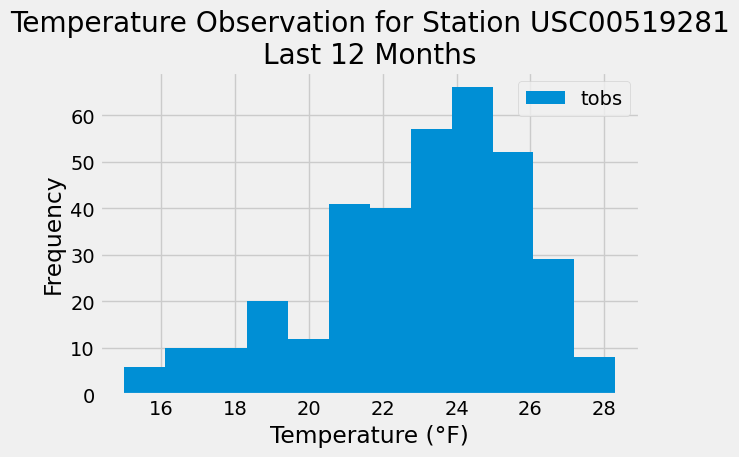

In [15]:
# Query to retrieve the last 12 months of temperature observation data for the most active station
temp_data = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_station)\
    .filter(Measurement.date >= one_year_ago).all()

# Convert the query results to a list
temperatures = [temp[0] for temp in temp_data]

# Plot the results as a histogram
plt.hist(temperatures, bins=12, label='tobs')
plt.title(f"Temperature Observation for Station {most_active_station}\nLast 12 Months")
plt.ylabel("Frequency")
plt.xlabel("Temperature (°F)")
plt.legend()
plt.tight_layout()
plt.show()


# Close Session

In [16]:
# Close Session
session.close()